In [19]:
from collections import deque
from imutils.video import VideoStream
import numpy as np
import argparse
import cv2
import imutils
import time

In [20]:
%matplotlib inline

In [21]:
import matplotlib.pyplot as plt

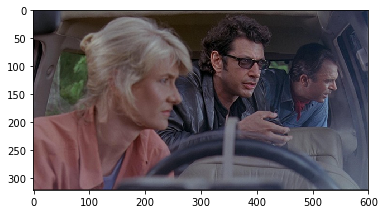

In [22]:
plt.imshow(plt.imread('../images/jurassic_park.png'))

In [24]:
from cv_course.lib import plot

In [8]:
buffer = 64

In [9]:
# define some constants in HSV color space
greenLower = (29, 86, 6)
greenUpper = (64, 255, 255)

blueLower = np.array([110,50,50])
blueUpper = np.array([130,255,255])

redUpper = (194, 194, 244)
redLower = (0, 0, 164)

In [10]:
lower, upper = greenLower, greenUpper

In [11]:
# then initialize the list of tracked points
pts = deque(maxlen=buffer)

In [12]:
videoPath = '../images/ball_tracking_example.mp4'

In [313]:
# videoPath = ''

In [13]:
# video or webcam
if videoPath == '':
    vs = VideoStream(src=0).start()
else:
    vs = cv2.VideoCapture(videoPath)

# allow the camera or video file to warm up
time.sleep(2.0)

In [14]:
# pasamos 20 frames para que aparezca la bola 
for j in range(20):
    frame = vs.read()
    frame = frame[1] if videoPath else frame

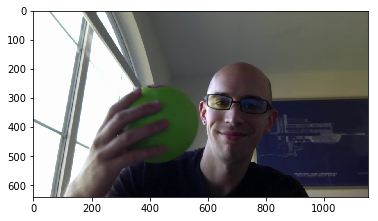

In [17]:
plot(frame)

In [317]:
# resize, blur, and convert it to HSV
frame = imutils.resize(frame, width=600)
blurred = cv2.GaussianBlur(frame, (11, 11), 0)
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

In [318]:
# construct a mask for the color you chose
mask = cv2.inRange(hsv, lower, upper)

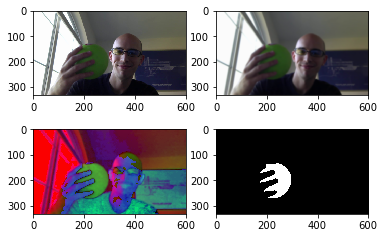

In [319]:
plot(frame, blurred, hsv, mask)

In [320]:
# then perform a series of dilations and erosions to remove any small blobs left in the mask
eroded = cv2.erode(mask, None, iterations=2)

In [321]:
final = cv2.dilate(eroded, None, iterations=2)

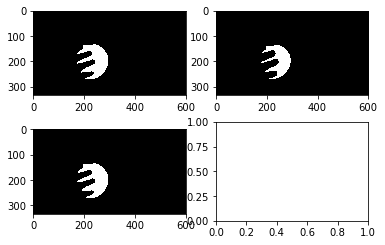

In [322]:
plot(mask, eroded, final)

__GO AHEAD__

In [323]:
# keep looping
while True:
    frame = vs.read()
    frame = frame[1] if videoPath else frame

    # if end of video, break
    if frame is None:
        break

    # resize, blur, and convert it to HSV
    frame = imutils.resize(frame, width=600)
    blurred = cv2.GaussianBlur(frame, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

    # construct a mask for the color, then perform a series of dilations and erosions to remove any small blobs left in the mask
    mask = cv2.inRange(hsv, lower, upper)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)

    # find contours in the mask and initialize the current
    # (x, y) center of the ball
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    center = None

    # only proceed if at least one contour was found
    if len(cnts) > 0:
        # find the largest contour in the mask, then use
        # it to compute the minimum enclosing circle and
        # centroid
        c = max(cnts, key=cv2.contourArea)
        ((x, y), radius) = cv2.minEnclosingCircle(c)
        M = cv2.moments(c)
        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

        # only proceed if the radius meets a minimum size
        if radius > 10:
            # draw the circle and centroid on the frame,
            # then update the list of tracked points
            cv2.circle(frame, (int(x), int(y)), int(radius),
                (0, 255, 255), 2)
            cv2.circle(frame, center, 5, (0, 0, 255), -1)

    # update the points queue
    pts.appendleft(center)

    # loop over the set of tracked points
    for i in range(1, len(pts)):
        # if either of the tracked points are None, ignore
        # them
        if pts[i - 1] is None or pts[i] is None:
            continue

        # otherwise, compute the thickness of the line and
        # draw the connecting lines
        thickness = int(np.sqrt(buffer / float(i + 1)) * 2.5)
        cv2.line(frame, pts[i - 1], pts[i], (0, 0, 255), thickness)

    # show the frame to our screen
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    # if the 'q' key is pressed, stop the loop
    if key == ord("q"):
        break

In [324]:
# if we are using webcam, stop stream
if videoPath == '':
    vs.stop()
else:
    vs.release()

# close all windows
cv2.destroyAllWindows()